# Box Office Blueprint: Data-Driven Insights for a New Movie Studio

## Business Problem 

My company now sees all the big companies creating original video content and they want to get in on the fun. And have decided to create a new movie studio, but they don’t know anything about creating movies. So I will be exploring what types of films are currently doing the best at the box office and translate those findings into actionable insights that the head of the company's new movie studio can use to help decide what type of films to create.

## Objectives

I will be using a **Linear Regression Model** as we have numeric target variables such as **domestic_gross**, **foreign_gross** and **total_gross**. Linear regression is a fundamental predictive modeling technique suitable for estimating continuous outcomes based on one or more independent variables (e.g., year, studio). Below are the objectives I intend to focus on;

**1. Predict Domestic Box Office Revenue Based on Year and Studio**
- The goal is to  estimate how much a movie will earn in the U.S. based on its release year and the studio that produced it.

**2. Estimate Foreign Gross Earnings Using Domestic Performance**
- The goal is to use domestic gross as a predictor of international success.

**3. Predict Total Gross Revenue (Domestic + Foreign) Using Available Features**
- The goal is to create a model that predicts total revenue based on year, studio, and domestic gross.

**4. Analyze the Trend of Domestic Revenue Over Time**
- The goal is to use year as an independent variable to model trends in U.S. box office revenue.

**5. Compare Studio Impact on Revenue While Controlling for Year
- The goal is to measure how different studios affect revenue, accounting for changes over time.

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import zipfile
import os

%matplotlib inline

## Data Understanding

We load the box office data into a pandas DataFrame and preview the first few rows to understand its structure.

In [123]:
# Load the dataset
file_path = 'bom.movie_gross.csv'
df = pd.read_csv(file_path)

In [124]:
df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


### Check for Missing Values

We use `df.info()` and `df.isnull().sum()` to check the structure of the dataframe to identify missing values.

In [125]:
# Check basic structure and data types

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [126]:
df.isnull().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

### Checking for Duplicates

We use `df.duplicated().sum()` to check for duplicate values.

In [127]:
df.duplicated().sum()

0

## Data Preparation

Here I will be preparing the data by;

- Cleaning the **foreign_gross** column.
- Cleaning the **domestic_gross** column
- Ensuring correct data types and clean strings.
- Dropping the current **total_gross** column then re-creating it using **domestic_gross** + **foreign_gross**.
- Handling missing values.
- Strip Whitespace in String Columns

###  Cleaning foreign_gross Column

I will remove Remove commas/whitespace and convert the column to numeric.

In [128]:
# Remove commas/whitespace and convert to numeric
df['foreign_gross'] = (
    df['foreign_gross']
    .astype(str)
    .str.replace(',', '', regex=False)
    .str.strip()
    .replace('nan', pd.NA)
)
df['foreign_gross'] = pd.to_numeric(df['foreign_gross'], errors='coerce')

### Cleaning domestic_gross column

I will Convert domestic_gross to numeric.

In [129]:
# Convert 'domestic_gross' to numeric
df['domestic_gross'] = pd.to_numeric(df['domestic_gross'], errors='coerce')

### Ensuring correct data types and clean strings

I will Convert 'domestic_gross' to numeric and strip any whitespace.

In [130]:
# Convert 'domestic_gross' to numeric (just in case) and strip whitespace
df['domestic_gross'] = pd.to_numeric(df['domestic_gross'], errors='coerce')
df['title'] = df['title'].str.strip()
df['studio'] = df['studio'].str.strip()

### Handling Missing Values

I will drop rows missing any of the key values.

In [131]:
df_cleaned = df.dropna(subset=['domestic_gross', 'foreign_gross', 'studio'])

### Dropping the current **total_gross** column then re-creating it using **domestic_gross** + **foreign_gross**

I will Drop the existing total_gross column. Then recalculate total_gross from cleaned columns.

In [132]:
# Drop the existing total_gross column
df = df.drop(columns='total_gross', errors='ignore')

In [133]:
# Recalculate total_gross from cleaned columns
df_cleaned['total_gross'] = df_cleaned['domestic_gross'] + df_cleaned['foreign_gross']

In [134]:
df_cleaned

,title,studio,domestic_gross,foreign_gross,year,total_gross
0,Toy Story 3,BV,415000000.0,652000000.0,2010,1.067000e+09
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010,1.025500e+09
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010,9.603000e+08
3,Inception,WB,292600000.0,535700000.0,2010,8.283000e+08
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010,7.526000e+08
...,...,...,...,...,...,...
3275,I Still See You,LGF,1400.0,1500000.0,2018,1.501400e+06
3286,The Catcher Was a Spy,IFC,725000.0,229000.0,2018,9.540000e+05
3309,Time Freak,Grindstone,10000.0,256000.0,2018,2.660000e+05
3342,Reign of Judges: Title of Liberty - Concept Short,Darin Southa,93200.0,5200.0,2018,9.840000e+04


In [135]:
# Check remaining missing values
df_cleaned.isna().sum()

title             0
studio            0
domestic_gross    0
foreign_gross     0
year              0
total_gross       0
dtype: int64

In [136]:
df_cleaned.to_csv('cleaned_movie_gross.csv', index=False)

## Linear Regression Modelling

In this section I will create a linear regression model for the objectives set above. 

### Predict Domestic Gross Using Studio and Year

- The goal is to estimate how much a movie earns in the U.S. based on its **studio** and **year**.

In [137]:
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


In [138]:
# Keep only studios with at least 10 movies
top_studios = df_cleaned['studio'].value_counts()
top_studios = top_studios[top_studios >= 10].index

# Filter the DataFrame
df_obj1 = df_cleaned[df_cleaned['studio'].isin(top_studios)]

# One-hot encode 'studio', include 'year'
X1 = pd.get_dummies(df_obj1[['studio', 'year']], drop_first=True)
y1 = df_obj1['domestic_gross']

# Split the data into training amd testing sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Train the model
model1 = LinearRegression()
model1.fit(X1_train, y1_train)

# Evaluate the model
# Predict on test set
y1_pred = model1.predict(X1_test)

# Evaluate the model
print("R² Score:", r2_score(y1_test, y1_pred))
print("Mean Squared Error:", mean_squared_error(y1_test, y1_pred))

R² Score: 0.280511847150112
Mean Squared Error: 7354666959989772.0


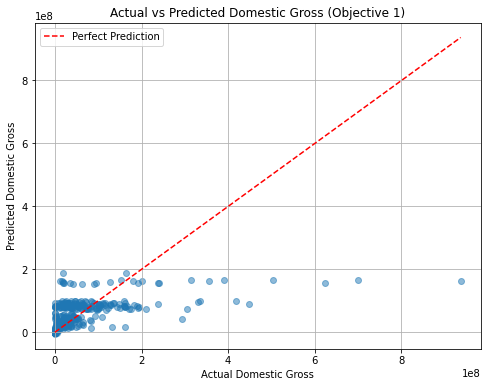

In [152]:
# Create a new figure for the plot with a defined size
plt.figure(figsize=(8, 6))

# Create a scatter plot of actual vs predicted domestic gross
plt.scatter(y1_test, y1_pred, alpha=0.5)

# Plot dashed line that shows what perfect predictions would look like
plt.plot([y1_test.min(), y1_test.max()],
         [y1_test.min(), y1_test.max()],
         'r--', label='Perfect Prediction')

# Label the X-axis with the true domestic gross values
plt.xlabel('Actual Domestic Gross')

# Label the Y-axis with the predicted domestic gross values
plt.ylabel('Predicted Domestic Gross')

# Add a title to describe what the chart is showing
plt.title('Actual vs Predicted Domestic Gross (Objective 1)')

# Add grid lines to improve readability
plt.grid(True)

# Show the legend 
plt.legend()

# Save visualization
plt.savefig('objective1__actual_vs_predicted_domestic_gros.png', dpi=300, bbox_inches='tight')

# Display the final plot
plt.show()

###  Predict Foreign Gross from Domestic Gross

The goal is to use domestic earnings to predict international success.

In [140]:
# Select the feature: 'domestic_gross' will be used to predict foreign gross
X2 = df_cleaned[['domestic_gross']]

# Select the target variable: 'foreign_gross' is what we're trying to predict
y2 = df_cleaned['foreign_gross']

# Split the data into training and testing sets (80% train, 20% test)
# This ensures the model is evaluated on unseen data
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Initialize the linear regression model
model2 = LinearRegression()

# Train the model using the training data
model2.fit(X2_train, y2_train)

# Predict foreign gross using the test data
y2_pred = model2.predict(X2_test)

# Evaluate the model using R² score (how well domestic gross predicts foreign gross)
print("Objective 2 R²:", r2_score(y2_test, y2_pred))

Objective 2 R²: 0.6994894672594614


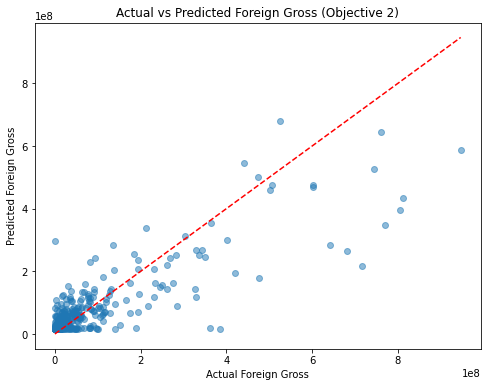

In [151]:
plt.figure(figsize=(8, 6))  # Set figure size

# Scatter plot of actual vs predicted values
plt.scatter(y2_test, y2_pred, alpha=0.5)

# Add a reference line 
# If all predictions were perfect, all points would fall on this line
plt.plot([y2_test.min(), y2_test.max()],
         [y2_test.min(), y2_test.max()],
         'r--', label='Perfect Prediction')

# Label the axes
plt.xlabel('Actual Foreign Gross')
plt.ylabel('Predicted Foreign Gross')

# Add a title to the plot
plt.title('Actual vs Predicted Foreign Gross (Objective 2)')

# save visualization
plt.savefig('objective2_actual_vs_predicted_foreign_gross', dpi=300, bbox_inches='tight')

# Show visualization
plt.show()

###  Predict Total Gross Using All Numeric Features

The goal is to forecast full revenue using available numeric data.

In [142]:

# Keep only studios with at least 10 movies
top_studios = df_cleaned['studio'].value_counts()
top_studios = top_studios[top_studios >= 10].index

# Filter the DataFrame to include only those studios
df_obj3 = df_cleaned[df_cleaned['studio'].isin(top_studios)]

# One-hot encode the 'studio' column and include the 'year'
X3_realistic = pd.get_dummies(df_obj3[['studio', 'year']], drop_first=True)

# Target variable: total box office revenue
y3_realistic = df_obj3['total_gross']

# Split the data into training and testing sets (80/20 split)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3_realistic, y3_realistic, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model3_realistic = LinearRegression()
model3_realistic.fit(X3_train, y3_train)

# Predict total gross on the test set
y3_pred = model3_realistic.predict(X3_test)

# Evaluate the model
print("Objective 3 R²:", r2_score(y3_test, y3_pred))
print("Mean Squared Error:", mean_squared_error(y3_test, y3_pred))

Objective 3 R²: 0.2712448701958182
Mean Squared Error: 4.200407624467504e+16


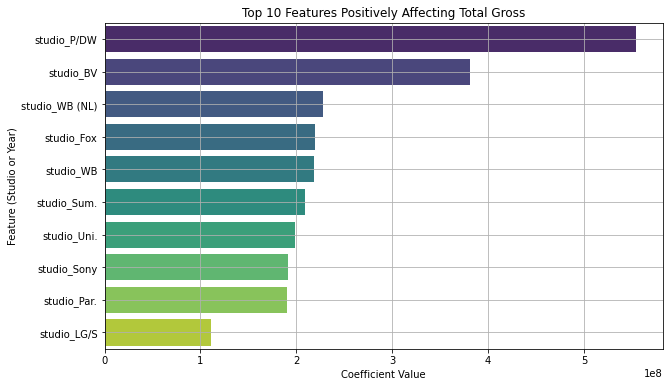

In [150]:
# Create a DataFrame to match feature names to model coefficients
coef_df = pd.DataFrame({
    'Feature': X3_realistic.columns,
    'Coefficient': model3_realistic.coef_
})

# Sort by impact
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# Plot top 10 positive impact features (e.g., big studios, strong years)
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(10), palette='viridis')
plt.title('Top 10 Features Positively Affecting Total Gross')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature (Studio or Year)')
plt.grid(True)

# save visualization
plt.savefig('objective3_top10_features_positively_affecting_total_gross.png', dpi=300, bbox_inches='tight')

# Show Visualization
plt.show()

### Analyze Domestic Revenue Trend Over Time

The goal is to check whether domestic revenue is increasing or decreasing across years.

In [144]:
# Select the feature: 'year' to assess how revenue changes over time
X4 = df_cleaned[['year']]

# Set the target: domestic gross revenue
y4 = df_cleaned['domestic_gross']

# Split the dataset into training (80%) and testing (20%) sets
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42)

# Initialize a linear regression model
model4 = LinearRegression()

# Train the model using the training data
model4.fit(X4_train, y4_train)

# Predict domestic gross using the model and the test set
y4_pred = model4.predict(X4_test)

# Evaluate how well 'year' alone predicts domestic gross using R² score
print("Objective 4 R²:", r2_score(y4_test, y4_pred))

Objective 4 R²: 0.027253426852850926


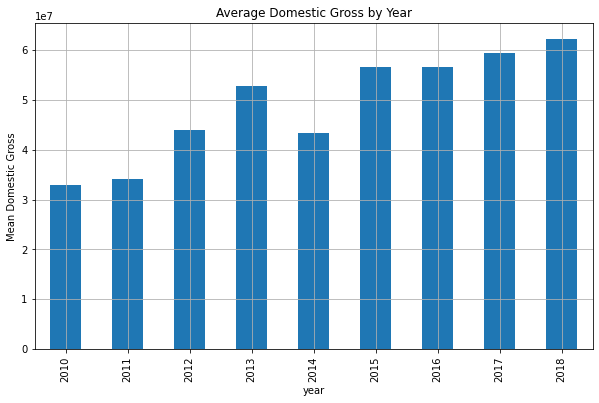

In [149]:
df_cleaned.groupby('year')['domestic_gross'].mean().plot(kind='bar', figsize=(10,6), title='Average Domestic Gross by Year')
plt.ylabel('Mean Domestic Gross')
plt.grid(True)

# save visualization
plt.savefig('objective4_average_domestic_gross_by_year.png', dpi=300, bbox_inches='tight')

# show visualization
plt.show()

###  Predict Total Gross While Controlling for Studio and Year

The goal is to estimate total revenue ehile isolating the impact of studio.

In [146]:
# Filter studios that have at least 10 movies to avoid noise from rare studios
top_studios = df_cleaned['studio'].value_counts()
top_studios = top_studios[top_studios >= 10].index
df_obj5 = df_cleaned[df_cleaned['studio'].isin(top_studios)]

# Define features
X5 = pd.get_dummies(df_obj5[['studio', 'year']], drop_first=True)

# Target variable is total_gross
y5 = df_obj5['total_gross']

# Split the data into training and test sets
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model5 = LinearRegression()
model5.fit(X5_train, y5_train)

# Predict on test set and evaluate
y5_pred = model5.predict(X5_test)

# Evaluate performance using R² and Mean Squared Error
print("Objective 5 R²:", r2_score(y5_test, y5_pred))
print("Mean Squared Error:", mean_squared_error(y5_test, y5_pred))


Objective 5 R²: 0.2712448701958182
Mean Squared Error: 4.200407624467504e+16


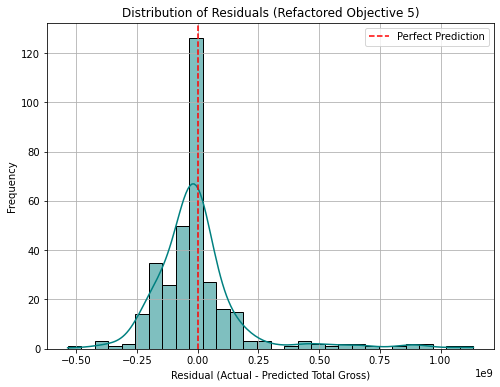

In [148]:
# Calculate residuals (difference between actual and predicted values)
residuals = y5_test - y5_pred

# Create the histogram
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color='teal')

# Label the plot
plt.title('Distribution of Residuals (Refactored Objective 5)')
plt.xlabel('Residual (Actual - Predicted Total Gross)')
plt.ylabel('Frequency')

# Add a vertical line at 0 to represent perfect predictions
plt.axvline(0, color='red', linestyle='--', label='Perfect Prediction')

# Show legend and grid
plt.legend()
plt.grid(True)

# save visualization
plt.savefig('objective5_total_gross_prediction.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Key Findings

## 1. Predict Domestic Gross Using Studio and Year

- R² Score = 0.2805 the model explains 28% of the variation in U.S. domestic gross revenue using only **studio** and **year**.
- Domestic box office earnings are partially predictable based on studio reputation and timing, with 28% of revenue variation explained by these features.

## 2. Predict Foreign Gross from Domestic Gross

- Objective 2 R²: 0.6994894672594614 means that about 70% of the variance in **foreign gross** is explained by **domestic gross.**
- Based on past data, a movie’s domestic box office performance is a strong predictor of its international success, explaining roughly 70% of the variation in foreign gross revenue

## 3. Predict Total Gross Using All Numeric Features

- Objective 3 R²: 0.2712448701958182 the model explains about 27% of the variation in total_gross using just studio and year.
- Before a movie is released, knowing the **studio** and **year** gives us a moderate ability to predict its total gross revenue. These two factors alone explain about 27% of box office performance, suggesting brand power and release timing matter — but more factors are needed for strong predictions.

## 4. Analyze Domestic Revenue Trend Over Time

- Objective 4 R²: 0.027253426852850926 means that only 2.7% of the variance in domestic gross is explained by the **year** of release. This means year alone is a very weak predictor of how much a movie earns domestically. The trend is likely noisy, with high-earning and low-earning films in every year.

- There is no meaningful upward or downward trend in domestic box office revenue across the years 2010–2018. Other factors (like genre, cast, marketing, or competition) are likely much more influential than release year alone.

## 5. Predict Total Gross While Controlling for Studio and Year

- Objective 5 R²: 0.2712448701958182 the model explains about 27% of the variation in total_gross using only studio and year.
- With only the **studio** and **year** available before launch, we can forecast a movie’s global revenue with moderate confidence. This insight is valuable for initial budgeting, marketing expectations, and risk planning

# Conclusion

This analysis explored key factors influencing box office performance using linear regression models. Our findings show that **studio reputation** and **release year** moderately predict **domestic and total gross revenues**, explaining around 27–28% of their variation. Notably, **domestic box office performance** is a strong predictor of foreign revenue, with a model explaining nearly 70% of international earnings, a valuable insight for global forecasting. Conversely, **release year** alone shows little predictive power, indicating that time trends have minimal influence without additional context. These results highlight that while pre-release factors like studio and timing provide useful signals, more detailed data such as genre, cast, and budget is essential for stronger predictive accuracy and strategic planning.